This model uses as features: 
* Customer demographics removing Comuna and Profesion (customer_feat)
* Old count history, previous 13 th month (old_history_feat) 
* Last 13 months count history (current_history_feat)
* Campains info


# Notebook Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install ml-metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=d248183d4d6c741bdcb256c121d64f8c70c664347aaeddab5cdc57ee053ec0dd
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/itau/

# Preparing Data

In [ ]:
import pandas as pd
import numpy as np
from dataset.dataset import Dataset

ModuleNotFoundError: ignored

In [ ]:
ds = Dataset()
#ds.load_data()

NameError: ignored

In [ ]:
###

In [ ]:
ds.campains_train_df.describe(include="all")

NameError: ignored

In [ ]:
ds.campains_train_df

,id,Id_Producto,Tipo,Producto-Tipo,Fecha_Campaña,Periodo,Resultado,Canal,Duracion_Campaña
0,1,A,A,A-A,2020-01-02,202001,0,B,1
1,1,B,B,B-B,2020-01-21,202001,0,C,1
2,1,A,A,A-A,2020-02-03,202002,0,B,1
3,1,B,B,B-B,2020-02-18,202002,0,C,1
4,1,A,A,A-A,2020-03-02,202003,0,B,1
...,...,...,...,...,...,...,...,...,...
493323,79539,B,B,B-B,2020-01-28,202001,0,C,1
493324,79539,C,D,C-D,2020-07-20,202007,0,C,1
493325,79539,A,A,A-A,2020-07-01,202007,0,B,1
493326,79539,B,B,B-B,2020-04-08,202004,0,C,1


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = (SparkSession.builder.appName("SparkSQLExampleApp").getOrCreate())
cp_df = spark.read.csv(str(ds.BASE_DATA_PATH/'Campanas_train.csv'), header=True)
cpt_df = spark.read.csv(str(ds.BASE_DATA_PATH/'Campanas_test.csv'), header=True)

In [ ]:
cp_df.groupby(['Producto-Tipo','Canal']).agg(F.countDistinct('Canal')).show()

+-------------+-----+------------+
|Producto-Tipo|Canal|count(Canal)|
+-------------+-----+------------+
|          A-A|    B|           1|
|          B-B|    C|           1|
|          C-D|    B|           1|
|          C-D|    C|           1|
|          D-E|    C|           1|
+-------------+-----+------------+



In [ ]:
cpt_df.groupby(['Producto-Tipo','Canal']).agg(F.countDistinct('Canal')).show()

+-------------+-----+------------+
|Producto-Tipo|Canal|count(Canal)|
+-------------+-----+------------+
|          A-A|    B|           1|
|          A-A|    C|           1|
|          B-B|    C|           1|
|          C-D|    B|           1|
|          C-D|    C|           1|
|          D-E|    C|           1|
+-------------+-----+------------+



In [ ]:
cp_results = cp_df.groupBy(['id','Producto-Tipo','Canal','Periodo']).agg(F.sum('Resultado').alias('results')).toPandas()
cp_events = cp_df.groupBy(['id','Producto-Tipo','Canal','Periodo']).agg(F.count('Producto-Tipo').alias('events')).toPandas()
cpt_events = cpt_df.groupBy(['id','Producto-Tipo','Canal','Periodo']).agg(F.count('Producto-Tipo').alias('events')).toPandas()

In [ ]:
cp_results = cp_results.set_index('id').set_index(['Producto-Tipo', 'Canal', 'Periodo'], append=True).sort_index().unstack([-1])#.fillna(-1)
cp_events = cp_events.set_index('id').set_index(['Producto-Tipo', 'Canal', 'Periodo'], append=True).sort_index().unstack([-1])#.fillna(-1)
cpt_events = cpt_events.set_index('id').set_index(['Producto-Tipo', 'Canal', 'Periodo'], append=True).sort_index().unstack([-1])#.fillna(-1)

In [ ]:
labels = pd.DataFrame(cp_results.iloc[:,-3:].sum(axis=1)>0, columns=["results"])

train_features_results = pd.DataFrame(cp_results.iloc[:,-6:-3])
train_features_results.reset_index([-1,-2], inplace=True)
train_features_results['Campain'] = train_features_results['Producto-Tipo'] + '/' + train_features_results['Canal']
train_features_results.drop(columns=['Producto-Tipo','Canal'], inplace=True)
train_features_results = train_features_results.set_index('Campain',append=True).unstack().sort_index()

train_features_events = pd.DataFrame(cp_events.iloc[:,-3:])
train_features_events.reset_index([-1,-2], inplace=True)
train_features_events['Campain'] = train_features_events['Producto-Tipo'] + '/' + train_features_events['Canal']
train_features_events.drop(columns=['Producto-Tipo','Canal'], inplace=True)
train_features_events = train_features_events.set_index('Campain',append=True).unstack().sort_index()

test_features_results = None #This is the output of the campain model

test_features_events = pd.DataFrame(cpt_events)
test_features_events.reset_index([-1,-2], inplace=True)
test_features_events['Campain'] = test_features_events['Producto-Tipo'] + '/' + test_features_events['Canal']
test_features_events.drop(columns=['Producto-Tipo','Canal'], inplace=True)
test_features_events = test_features_events.set_index('Campain',append=True).unstack().sort_index()
columns = [col for col in test_features_events.columns if col[-1]!='A-A/C']
test_features_events = test_features_events[columns]

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
train_features_results.index = train_features_results.index.map(int)
train_features_events.index = train_features_events.index.map(int)
test_features_events.index = test_features_events.index.map(int)

In [ ]:
index_df = pd.DataFrame(range(1,79540),columns=['id']).set_index('id')#train_features_events.sort_index()

In [ ]:
train_features_results = train_features_results.merge(index_df,how='right', left_index=True, right_index=True)
train_features_events = train_features_events.merge(index_df,how='right', left_index=True, right_index=True)
test_features_events = test_features_events.merge(index_df,how='right', left_index=True, right_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
train_features_results.fillna(0, inplace=True)
train_features_events.fillna(0, inplace=True)
test_features_events.fillna(0, inplace=True)

In [ ]:
train_features = np.hstack([train_features_results, train_features_events])

In [ ]:
labels=labels.unstack([-2,-1]).fillna(False).astype(int)
labels.index = labels.index.map(int)

In [ ]:
labels = labels.merge(index_df, how='right', left_index=True, right_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
train

In [ ]:
###

In [ ]:
ds.load_data()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
counts = ds.get_transactions_counts()

In [ ]:
def get_features(train=True):
  # Customer features
  customer_feat = pd.get_dummies(ds.customers_df.set_index("id").drop(columns=['Comuna','Profesion']))
  # Transactions features
  input_counts = counts.iloc[:,:-3].copy() if train else counts.copy() #-3 is because these are in the training features
  old_history_feat = pd.DataFrame((input_counts.iloc[:,:-13].sum(axis=1)>0).astype('float'),columns=['old_count']).unstack().fillna(0)
  current_history_feat = input_counts.iloc[:,-13:].unstack().fillna(0)
  # Full features
  features = np.hstack([customer_feat, old_history_feat, current_history_feat])
  return features

In [ ]:
# Features
train_features = np.hstack([get_features(train=True), train_features_events])
test_features = np.hstack([get_features(train=False), test_features_events])
# Labels
labels = (counts.iloc[:,-3:].sum(axis=1))
labels = labels.unstack(-1) > 0
actuals = [list(np.array(labels.columns)[x]) for x in labels.values]
labels = labels.astype(int)

In [ ]:
train_features.shape

(79539, 162)

## Competition Learning

In [ ]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model():
	# create model
  model = tf.keras.models.Sequential([tf.keras.layers.Dense(64,activation='relu'), 
           tf.keras.layers.Dense(16, activation='relu'),
           tf.keras.layers.Dense(5,activation='softmax')])
	# Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

callbacks=[tf.keras.callbacks.EarlyStopping(patience=15),
                                     tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.05)]
keras_model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

classifiers =[
               # Neural Network
               #-keras_model,
               #MultiOutputClassifier(XGBClassifier()),
               MultiOutputClassifier(LGBMClassifier()),
               # Trees
               ##DecisionTreeClassifier(),
               ##ExtraTreeClassifier(),
               # Ensemble
               #ExtraTreesClassifier(),
               #RandomForestClassifier(),
               # Neighbors
               #KNeighborsClassifier(n_neighbors=15),
               # Linear
               #MultiOutputClassifier(RidgeClassifierCV()),
]

In [ ]:
%%time
from time import time
from datetime import datetime
from sklearn.model_selection import cross_validate

filename = ds.BASE_PATH/'training'/f'competition_learning_results_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
training_summary = pd.DataFrame(columns=['test_score_mean','test_score_3_std','train_score_mean','train_score_3_std','model_name','model_params'])

for i, model in enumerate(classifiers):
  tic = time()
  classifier = model
  classifier_name = classifier.__class__.__name__
  print(classifier_name)
  cv = cross_validate(model, train_features, labels, cv=10, return_train_score=True, scoring='roc_auc', verbose=1)
  new_line = pd.Series({
      'starting_pos': i,
      'test_score_mean': cv['test_score'].mean(),
      'test_score_3_std': 3*cv['test_score'].std(),
      'train_score_mean': cv['train_score'].mean(),
      'train_score_3_std': 3*cv['train_score'].std(),
      'model_name': classifier_name,
      'training_time': time()-tic,
      'model_params': classifier.get_params()
  })
  training_summary = training_summary.append(new_line,ignore_index=True)
  training_summary.sort_values(by="test_score_mean", inplace=True, ascending=False)
  training_summary.to_csv(filename)

training_summary

MultiOutputClassifier


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 3min 55s, sys: 1.3 s, total: 3min 57s
Wall time: 2min 2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min finished


In [ ]:
training_summary

,test_score_mean,test_score_3_std,train_score_mean,train_score_3_std,model_name,model_params,starting_pos,training_time
0,0.829515,0.02775,0.897036,0.004662,MultiOutputClassifier,"{'estimator__boosting_type': 'gbdt', 'estimato...",0.0,122.923878


## Checking the performance

In [ ]:
from sklearn.model_selection import train_test_split
from utils import mAP
X_train, X_test, y_train, y_test = train_test_split(train_features, labels)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"Perfect mAP: {mAP(y_true=y_train.values, y_pred=y_train.values)}")
print(f"Train mAP: {mAP(y_true=y_train.values, y_pred=train_preds)}")
print(f"Test mAP: {mAP(y_true=y_test.values, y_pred=test_preds)}")

Perfect mAP: 0.5284641432259363
Train mAP: 0.42268500668670816
Test mAP: 0.4123885955354399


# Fine Tuning

In [ ]:
%%time
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

model = MultiOutputClassifier(LGBMClassifier())
param_grid = [{'estimator__boosting_type': ['gbdt'],
 'estimator__class_weight': [None],
 'estimator__colsample_bytree': [1.0],
 'estimator__importance_type': ['split'],
 'estimator__learning_rate': [0.1],
 'estimator__max_depth': [-1],
 'estimator__min_child_samples': [20, 40], # 20 better than 40
 'estimator__min_child_weight': [0.001],
 'estimator__min_split_gain': [0.0],
 'estimator__n_estimators': [50, 200], # 50 better than 100 and 200
 'estimator__n_jobs': [-1],
 'estimator__num_leaves': [31, 51], #31 better than 51
 'estimator__objective': [None],
 'estimator__random_state': [None],
 'estimator__reg_alpha': [0.0],
 'estimator__reg_lambda': [0.0],
 'estimator__silent': [True],
 'estimator__subsample': [1.0],
 'estimator__subsample_for_bin': [200000],
 'estimator__subsample_freq': [0]
               }]
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(train_features, labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.4min finished


CPU times: user 15.9 s, sys: 578 ms, total: 16.5 s
Wall time: 8min 34s


In [ ]:
cvres = grid_search.cv_results_
print("--------------MEAN-TEST-SCORE--------------------")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("{} {}".format(mean_score, params))

print("---------------3-*-STD--------------------")
for std_score, params in zip(cvres["std_test_score"], cvres["params"]):
    print("{} {}".format(3*std_score, params))

print("--------------MEAN-TRAIN-SCORE--------------------")
for mean_score, params in zip(cvres["mean_train_score"], cvres["params"]):
    print("{} {}".format(mean_score, params))

--------------MEAN-TEST-SCORE--------------------
0.8317365020842378 {'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 50, 'estimator__n_jobs': -1, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': None, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__silent': True, 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0}
0.8302428046694367 {'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child

## Checking the performance

In [ ]:
from sklearn.model_selection import train_test_split
from utils import mAP
X_train, X_test, y_train, y_test = train_test_split(train_features, labels)
model = MultiOutputClassifier(LGBMClassifier())
model.set_params(**grid_search.best_params_)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f"Perfect mAP: {mAP(y_true=y_train.values, y_pred=y_train.values)}")
print(f"Train mAP: {mAP(y_true=y_train.values, y_pred=train_preds)}")
print(f"Test mAP: {mAP(y_true=y_test.values, y_pred=test_preds)}")

Perfect mAP: 0.5260502229523586
Train mAP: 0.41825750718029525
Test mAP: 0.4192329505769284


## Checking importances

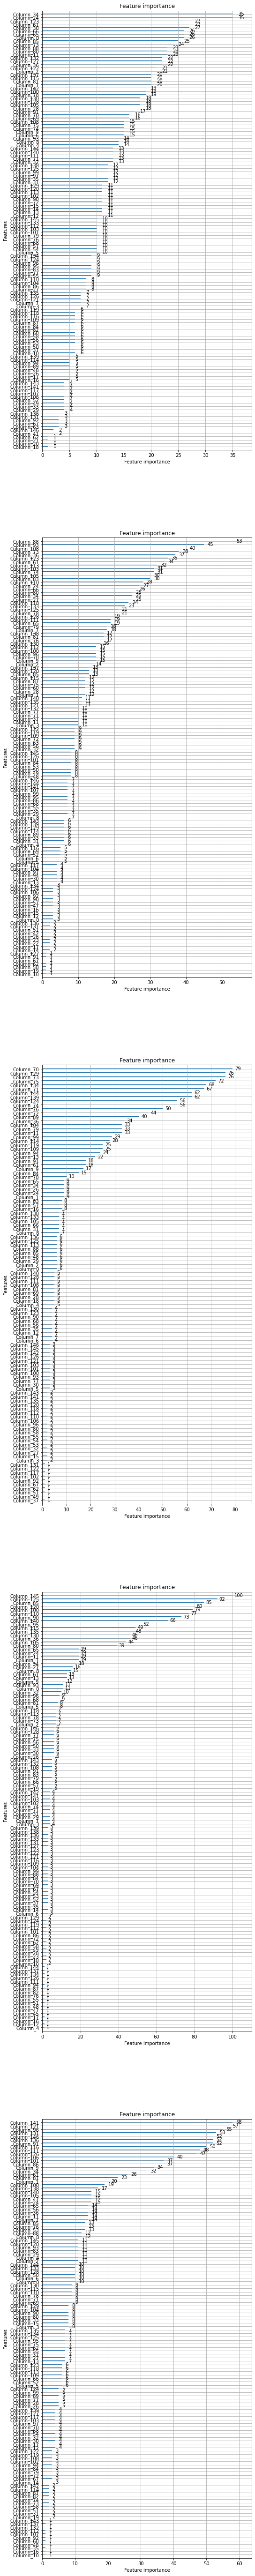

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
f, axs = plt.subplots(5,1, figsize=(8,100))
for i, ax in enumerate(axs): 
    plot_importance(model.estimators_[i], ax=ax)

# Submission

In [ ]:
model = MultiOutputClassifier(LGBMClassifier())
model.set_params(**grid_search.best_params_)
model.fit(train_features, labels)

MultiOutputClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.1, max_depth=-1,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0.0,
                                               n_estimators=50, n_jobs=-1,
                                               num_leaves=31, objective=None,
                                               random_state=None, reg_alpha=0.0,
                                               reg_lambda=0.0, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=

In [ ]:
from utils import from_preds_to_products
preds = model.predict_proba(test_features)

In [ ]:
product_preds = from_preds_to_products(preds)

In [ ]:
entrega_df = pd.read_csv(ds.BASE_DATA_PATH / 'ejemplo_entregaVF.csv', index_col='id')
entrega_df['productos'] = [" ".join(x) for x in product_preds]
from datetime import datetime
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)